In [1]:
from dp_datagen import generate_domain_points_1d_transient, generate_ic_points_1d, generate_dirichlet_bc_points_1d, generate_neumann_bc_points_1d, q_flux_gaussian, q_flux_normal, normalise
from dp_heat_net_trans import HeatNet1DTransient
from dp_loss_fns import pde_loss_1d_transient, ic_loss, dirichlet_bc_loss, neumann_bc_loss

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


In [2]:
# Parameter definitions


#physical params
L = 0.01
t_final = 10.0
T_initial = 300.0
T_coolant = 300.0

k = 170.0  # Thermal conductivity (Tungsten)
rho = 19300.0  # density (Tungsten)
c_p = 130.0  # specific heat capacity (tungsten)
alpha = k / (rho * c_p)  # thermal diffusivity



#ELM pulse parameters
q_max = 2e7
t_peak = 1.5
width = 1e-3
q_flux_params = {'q_max': q_max, 't_peak': t_peak, 'width': width}

# Data generation parameters
n_domain = 10000
n_ic = 5000
n_bc = 5000

# Network hyperparameters
n_units = 80
num_frequencies = 16
fourier_scale = 1.0
lr = 0.001
epochs = 1000

# Loss weights
w_pde = 1.0
w_ic = 1.0
w_bc0 = 1.0
w_bcL = 1.0

In [3]:
#==================================================================================
# 1. Parameter Definitions
#==================================================================================
# --- Physical & Simulation Parameters ---
L = 0.01
t_final = 10.0
T_initial = 300.0
T_coolant = 300.0

# --- Material Properties (for the PDE loss function) ---
k = 170.0      # Thermal conductivity (Tungsten)
rho = 19300.0    # Density (Tungsten)
c_p = 130.0      # Specific heat capacity (Tungsten)
alpha = k / (rho * c_p)

# --- Data Generation Parameters ---
n_domain = 10000
n_ic = 5000
n_bc = 5000

# --- "Normal Running" Heat Flux Parameters ---
# These parameters match the q_flux_normal function called below
q_value = 5e5
t_start = 0.0
t_end = 2.0
q_flux_params = {'q_value': q_value, 't_start': t_start, 't_end': t_end}

# --- Normalization Parameters ---
# Estimated peak temperature for normalization. Even with a normal pulse, the
# temperature will rise, so you need a reasonable upper bound.
T_max_expected = 800.0

#==================================================================================
# 2. Data Generation
#==================================================================================
x_domain, t_domain = generate_domain_points_1d_transient(n_domain, L, t_final)
x_ic, t_ic, T_ic = generate_ic_points_1d(n_ic, L, T_initial)
x_bc0, t_bc0, q_bc0 = generate_neumann_bc_points_1d(
    n_bc, t_final, q_flux_func=q_flux_normal, q_flux_params=q_flux_params
)
x_bcL, t_bcL, T_bcL = generate_dirichlet_bc_points_1d(n_bc, L, t_final, T_coolant)

#==================================================================================
# 3. Normalise the Data
#==================================================================================
def normalise(x, xmin, xmax):
    """Scales a variable to the [0, 1] range."""
    if (xmax - xmin) == 0:
        return x * 0.0
    return (x - xmin) / (xmax - xmin)

# Define scaling min/max values based on parameters
x_min, x_max = 0.0, L
t_min, t_max = 0.0, t_final
T_min, T_max = T_coolant, T_max_expected
q_min, q_max_norm = 0.0, q_value # Use q_value for normalization

# Apply the normalization
x_domain_norm = normalise(x_domain, x_min, x_max)
t_domain_norm = normalise(t_domain, t_min, t_max)

x_ic_norm = normalise(x_ic, x_min, x_max)
t_ic_norm = normalise(t_ic, t_min, t_max)
T_ic_norm = normalise(T_ic, T_min, T_max)

x_bc0_norm = normalise(x_bc0, x_min, x_max)
t_bc0_norm = normalise(t_bc0, t_min, t_max)
q_bc0_norm = normalise(q_bc0, q_min, q_max_norm)

x_bcL_norm = normalise(x_bcL, x_min, x_max)
t_bcL_norm = normalise(t_bcL, t_min, t_max)
T_bcL_norm = normalise(T_bcL, T_min, T_max)

#==================================================================================
# 4. Convert NORMALIZED Data from NumPy to PyTorch Tensors
#==================================================================================
def np_to_torch(arr):
    return torch.from_numpy(arr).to(torch.float32).to(device)

# --- These tensors are inputs to the model for calculating the PDE residual ---
x_domain_torch = np_to_torch(x_domain_norm).requires_grad_(True)
t_domain_torch = np_to_torch(t_domain_norm).requires_grad_(True)

# --- These tensors are for calculating the Initial Condition loss ---
x_ic_torch = np_to_torch(x_ic_norm)
T_ic_torch = np_to_torch(T_ic_norm)

# --- These tensors are for calculating the Neumann BC (x=0) loss ---
t_bc0_torch = np_to_torch(t_bc0_norm).requires_grad_(True)
q_bc0_torch = np_to_torch(q_bc0_norm)

# --- These tensors are for calculating the Dirichlet BC (x=L) loss ---
t_bcL_torch = np_to_torch(t_bcL_norm)
T_bcL_torch = np_to_torch(T_bcL_norm)

Epoch 0: Loss_tot 4.6860e-03 | PDE 4.6860e-03
Epoch 50: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 100: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 150: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 200: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 250: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 300: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 350: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 400: Loss_tot 0.0000e+00 | PDE 0.0000e+00
Epoch 450: Loss_tot 0.0000e+00 | PDE 0.0000e+00


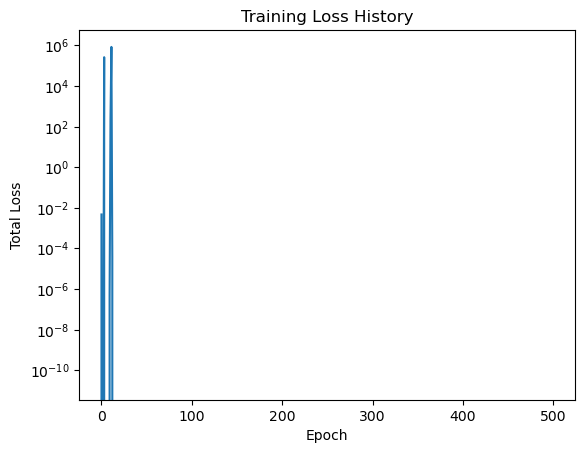

In [4]:
# Instantiate the model

model = HeatNet1DTransient(
    input_dim=2, output_dim=1, n_units=n_units,
    use_ffe=False, num_frequencies=num_frequencies, fourier_scale=fourier_scale,
).to(device)

losses = model.fit(
    x_domain_torch, t_domain_torch,
    x_ic_torch, T_ic_torch,
    t_bc0_torch, q_bc0_torch, k,
    t_bcL_torch, L, T_bcL_torch,
    alpha,
    epochs=500,
    lr=1,
    w_pde=1.0, w_ic=1000.0, w_bc0=1000.0, w_bcL=1000.0
)


# Training the model

plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss History')
plt.show()